# Projet Scraping de données 
## Cartographie des Happy Hours à Toulouse

Importation des packages

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import math
from selenium import webdriver
from selenium.webdriver.chrome.service import Service  
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

- Partie 1 : Extraction des données

1.

In [67]:
s = Service('C:/Users/axelp/OneDrive/Bureau/IA School/Info/scraping/chromedriver-win64/chromedriver.exe')
driver = webdriver.Chrome(service=s)

driver.get("https://www.schlouk-map.com/fr/cities/toulouse/happy-hour")

time.sleep(1) 

cookies = driver.find_element(By.CLASS_NAME, "fc-button-label")
cookies.click()

time.sleep(1) 

site1 = driver.page_source

driver.get("https://www.schlouk-map.com/fr/cities/toulouse/happy-hour?page=2")

site2 = driver.page_source

driver.back()

site = site1 + site2






In [68]:
soup = BeautifulSoup(site, 'html.parser')
bar = soup.find_all('a', class_="name")

all_bar = []
all_href = []

for i in bar:
    all_bar.append(i.text.strip())
    all_href.append('https://www.schlouk-map.com'+i['href'])


In [69]:
prix = soup.find_all('p', class_="text-truncate mb-2 text-secondary")

# Liste pour stocker les prix
all_prix = []

for i in prix:
    match = re.search(r'\d,\d{2}', i.text)
    if match:
        prix_decimal = float(match.group(0).replace(',', '.'))
        all_prix.append(prix_decimal)
    else:
        all_prix.append(None)



In [70]:
adresse = soup.find_all('p', class_="text-truncate mb-0 text-secondary")

all_adresse = []
for i in adresse:
    all_adresse.append(i.text.strip())

In [72]:
all_horaires = []
all_services_oui = []
prix_normal = []
prix_happyhour = []

for i in range(len(all_href)):
    driver.get(all_href[i])
    time.sleep(1)
    barpage = driver.page_source
    soup = BeautifulSoup(barpage, 'html.parser')

    table = soup.find('table', class_="table table-sm table-borderless table-drinks")
    if table:
        tbody_rows = table.find('tbody').find_all('tr')
        premier_td = tbody_rows[0].find_all('td', class_="font-weight-bold text-right")[0]
        second_td = tbody_rows[0].find_all('td', class_="font-weight-bold text-right")[1]
        match = re.search(r'\d,\d{2}', second_td.text)
        match1 = re.search(r'\d,\d{2}', premier_td.text)
    
        if match:    
            prix_normal_dec = float(match.group(0).replace(',', '.'))
            prix_normal.append(prix_normal_dec)
        else:
            prix_normal.append(None)
        if match1:
            prix_hh_dec = float(match1.group(0).replace(',', '.'))
            prix_happyhour.append(prix_hh_dec)
        else:
            prix_happyhour.append(None)
    else: 
        prix_normal.append(None)
        prix_happyhour.append(None)

    ouverture = soup.find_all('div', class_="col-lg-6 mb-3 mb-md-0")
    horaires = []
    for element in ouverture:
        jours = element.find_all("td", class_=None)
        heures = element.find_all(class_="float-right float-md-none")
        horaires += [f"{jour.get_text()} {heure.get_text()}" for jour, heure in zip(jours, heures)]
    horaires_texte = " ".join(horaires).replace('\n', '')
    all_horaires.append(horaires_texte)

    services_oui = []
    table = soup.find("table", class_="table table-sm table-borderless table-services mb-0")
    for row in table.find_all("tr"):
        td_right_text = row.find("td", class_="float-right float-md-none").get_text(strip=True)
        if td_right_text == "Oui":
            service_text = row.find("td", class_="text-truncate").get_text(strip=True)
            services_oui.append(service_text)
    
    all_services_oui.append(", ".join(services_oui))

2.

In [93]:
data = {'Bar': all_bar, 'Lien': all_href, 'Prix_happy_hour': prix_happyhour, 'Prix_normal': prix_normal,'Adresse': all_adresse, 'Horaires': all_horaires, 'Services': all_services_oui}

# Créer le DataFrame
df = pd.DataFrame(data)
df

,Bar,Lien,Prix_happy_hour,Prix_normal,Adresse,Horaires,Services
0,Matabiau Décapsule Club,https://www.schlouk-map.com/fr/places/matabiau...,3.7,4.9,"74 Rue Matabiau, 31000 Toulouse",Lundi 15:30 - 20:00 Mardi 13:00 - 23:00 Mercre...,"Restauration, Vente à emporter, Wifi gratuit, ..."
1,Tom Pouce,https://www.schlouk-map.com/fr/places/tom-pouce,5.5,7.0,"4 Place Roger Salengro, 31000 Toulouse",Lundi 10:30 - 20:00 Mardi 10:30 - 20:00 Mercre...,"Terrasse, Restauration, Vente à emporter, 🌬Air..."
2,The Black Lion,https://www.schlouk-map.com/fr/places/the-blac...,4.0,NaN,"4 Allées Paul Feuga, 31000 Toulouse",Lundi 08:30 - 02:00 Mardi 08:30 - 02:00 Mercre...,"Terrasse, Restauration, Diffusion de matchs, F..."
3,Barricot,https://www.schlouk-map.com/fr/places/barricot,NaN,8.2,"8 Esp. Compans Caffarelli, 31000 Toulouse",Lundi 12:00 - 22:00 Mardi 12:00 - 22:00 Mercre...,"Terrasse, Restauration"
4,La Maison,https://www.schlouk-map.com/fr/places/la-maison-1,4.0,NaN,"9 Rue Gabriel Pérri, 31000 Toulouse",Lundi 17:30 - 02:00 Mardi 17:30 - 02:00 Mercre...,"Terrasse, Restauration, Concerts / Musique Live"
...,...,...,...,...,...,...,...
62,The Melting Pot Pub,https://www.schlouk-map.com/fr/places/the-melt...,4.7,6.2,"26 Boulevard de Strasbourg, 31000 Toulouse",Lundi 12:00 - 02:00 Mardi 12:00 - 02:00 Mercre...,"Terrasse, Wifi gratuit, Diffusion de matchs, 🌬..."
63,Les Tricheurs,https://www.schlouk-map.com/fr/places/les-tric...,5.0,NaN,"34 Rue des Blanchers, 31000 Toulouse",Lundi 17:00 - 01:00 Mardi 17:00 - 01:00 Mercre...,Jeux de société
64,Baraka Jeux,https://www.schlouk-map.com/fr/places/baraka-j...,3.9,NaN,"1 Boulevard de la Gare, 31500 Toulouse",Lundi 17:00 - 01:00 Mardi 17:00 - 01:00 Mercre...,"Terrasse, Restauration"
65,Dada,https://www.schlouk-map.com/fr/places/dada,4.0,NaN,"27 Avenue Honoré Serres, 31000 Toulouse",Lundi 18:00 - 00:00 Mardi 18:00 - 02:00 Mercre...,"Terrasse, Restauration, Wifi gratuit, Accès & ..."


In [11]:
df.to_csv('data.csv', index=False)

- Partie 2 : Analyse de données

In [94]:
def calculer_reduction(row):
    prix_normal = row['Prix_normal']
    prix_happy_hour = row['Prix_happy_hour']
    
    # Vérifier si les deux prix sont non nuls
    if pd.notna(prix_normal) and pd.notna(prix_happy_hour):
        reduction = (prix_normal - prix_happy_hour) / prix_normal * 100
        return round(reduction,1)
    else:
        return None  # Retourner None si l'un ou l'autre prix est manquant

# Appliquer la fonction à chaque ligne du DataFrame pour créer la nouvelle colonne
df['Pourcentage_réduction'] = df.apply(calculer_reduction, axis=1)

# Afficher le DataFrame avec la nouvelle colonne
df

,Bar,Lien,Prix_happy_hour,Prix_normal,Adresse,Horaires,Services,Pourcentage_réduction
0,Matabiau Décapsule Club,https://www.schlouk-map.com/fr/places/matabiau...,3.7,4.9,"74 Rue Matabiau, 31000 Toulouse",Lundi 15:30 - 20:00 Mardi 13:00 - 23:00 Mercre...,"Restauration, Vente à emporter, Wifi gratuit, ...",24.5
1,Tom Pouce,https://www.schlouk-map.com/fr/places/tom-pouce,5.5,7.0,"4 Place Roger Salengro, 31000 Toulouse",Lundi 10:30 - 20:00 Mardi 10:30 - 20:00 Mercre...,"Terrasse, Restauration, Vente à emporter, 🌬Air...",21.4
2,The Black Lion,https://www.schlouk-map.com/fr/places/the-blac...,4.0,NaN,"4 Allées Paul Feuga, 31000 Toulouse",Lundi 08:30 - 02:00 Mardi 08:30 - 02:00 Mercre...,"Terrasse, Restauration, Diffusion de matchs, F...",NaN
3,Barricot,https://www.schlouk-map.com/fr/places/barricot,NaN,8.2,"8 Esp. Compans Caffarelli, 31000 Toulouse",Lundi 12:00 - 22:00 Mardi 12:00 - 22:00 Mercre...,"Terrasse, Restauration",NaN
4,La Maison,https://www.schlouk-map.com/fr/places/la-maison-1,4.0,NaN,"9 Rue Gabriel Pérri, 31000 Toulouse",Lundi 17:30 - 02:00 Mardi 17:30 - 02:00 Mercre...,"Terrasse, Restauration, Concerts / Musique Live",NaN
...,...,...,...,...,...,...,...,...
62,The Melting Pot Pub,https://www.schlouk-map.com/fr/places/the-melt...,4.7,6.2,"26 Boulevard de Strasbourg, 31000 Toulouse",Lundi 12:00 - 02:00 Mardi 12:00 - 02:00 Mercre...,"Terrasse, Wifi gratuit, Diffusion de matchs, 🌬...",24.2
63,Les Tricheurs,https://www.schlouk-map.com/fr/places/les-tric...,5.0,NaN,"34 Rue des Blanchers, 31000 Toulouse",Lundi 17:00 - 01:00 Mardi 17:00 - 01:00 Mercre...,Jeux de société,NaN
64,Baraka Jeux,https://www.schlouk-map.com/fr/places/baraka-j...,3.9,NaN,"1 Boulevard de la Gare, 31500 Toulouse",Lundi 17:00 - 01:00 Mardi 17:00 - 01:00 Mercre...,"Terrasse, Restauration",NaN
65,Dada,https://www.schlouk-map.com/fr/places/dada,4.0,NaN,"27 Avenue Honoré Serres, 31000 Toulouse",Lundi 18:00 - 00:00 Mardi 18:00 - 02:00 Mercre...,"Terrasse, Restauration, Wifi gratuit, Accès & ...",NaN


In [95]:
# Trier le DataFrame par la colonne 'Pourcentage de réduction' dans l'ordre décroissant
df_sorted = df.sort_values(by='Pourcentage_réduction', ascending=False)
df_sorted

# Afficher les cinq premières lignes du DataFrame trié
top_5 = df_sorted.head(5)
top_5


,Bar,Lien,Prix_happy_hour,Prix_normal,Adresse,Horaires,Services,Pourcentage_réduction
48,Chez Tonton,https://www.schlouk-map.com/fr/places/chez-tonton,1.0,2.0,"16 Place Saint-Pierre, 31000 Toulouse",Lundi 07:00 - 02:00 Mardi 07:00 - 02:00 Mercre...,"Terrasse, Restauration, Diffusion de matchs, 🌬...",50.0
49,Wanted Jack Saloon,https://www.schlouk-map.com/fr/places/wanted-j...,4.0,7.0,"2 Rue Raymond IV, 31000 Toulouse",Lundi Fermé Mardi 17:00 - 02:00 Mercredi 17:00...,"Terrasse, Restauration, Wifi gratuit, 🌬Air cli...",42.9
20,MAD (Meet and Drink),https://www.schlouk-map.com/fr/places/mad-meet...,3.0,5.0,"4 Allées Charles de Fitte, 31300 Toulouse",Lundi 17:00 - 02:00 Mardi 17:00 - 02:00 Mercre...,"Terrasse, Restauration, Diffusion de matchs, A...",40.0
58,Bar Des Zés,https://www.schlouk-map.com/fr/places/bar-des-zes,3.5,5.5,"49 Rue Pargaminières, 31000 Toulouse",Lundi 18:00 - 02:00 Mardi 18:00 - 02:00 Mercre...,"Terrasse, Restauration, Diffusion de matchs, F...",36.4
12,The Frog & Rosbif,https://www.schlouk-map.com/fr/places/the-frog...,5.0,7.5,"14 Rue de l'Industrie, 31000 Toulouse",Lundi 17:00 - 00:00 Mardi 17:00 - 01:00 Mercre...,"Terrasse, Restauration, Vente à emporter, Wifi...",33.3


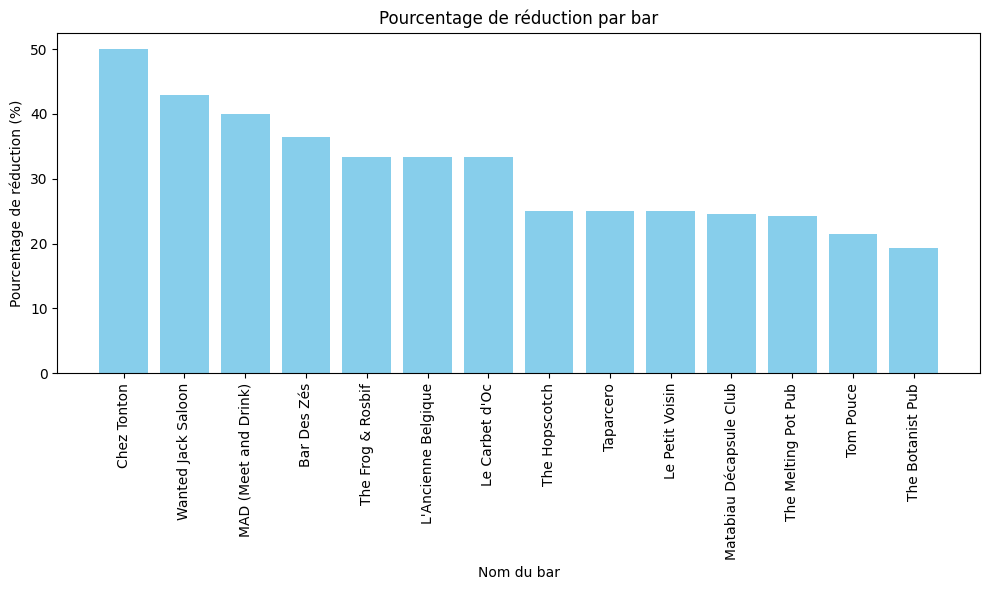

In [96]:
import matplotlib.pyplot as plt

df_filtered = df_sorted[df_sorted['Pourcentage_réduction'] > 0]

# Extraire les noms des bars et les pourcentages de réduction
noms_bars = df_filtered['Bar']
pourcentages_reduction = df_filtered['Pourcentage_réduction']

# Créer un graphique en barres
plt.figure(figsize=(10, 6))
plt.bar(noms_bars, pourcentages_reduction, color='skyblue')

# Ajouter des titres et des étiquettes
plt.title('Pourcentage de réduction par bar')
plt.xlabel('Nom du bar')
plt.ylabel('Pourcentage de réduction (%)')
plt.xticks(rotation=90)  # Faire pivoter les étiquettes de l'axe x pour une meilleure lisibilité

# Afficher le graphique
plt.tight_layout()
plt.show()

    

- Partie 3 : Rapport par E-mail

In [98]:
from jinja2 import Environment, FileSystemLoader

# Charger le répertoire contenant les templates
env = Environment(loader=FileSystemLoader('C:/Users/axelp/OneDrive/Bureau/IA School/Info/scraping/'))

# Charger le template HTML
template = env.get_template('report_template.html')

# Simuler des données (remplacer par les données réelles extraites et analysées)
bars = [
    {'name': df_sorted.iloc[0]['Bar'], 'address': df_sorted.iloc[0]['Adresse'], 'happy_hour_price': df_sorted.iloc[0]['Prix_happy_hour'], 'normal_price': df_sorted.iloc[0]['Prix_normal'], 'savings': df_sorted.iloc[0]['Pourcentage_réduction']},
    {'name': df_sorted.iloc[1]['Bar'], 'address': df_sorted.iloc[1]['Adresse'], 'happy_hour_price': df_sorted.iloc[1]['Prix_happy_hour'], 'normal_price': df_sorted.iloc[1]['Prix_normal'], 'savings': df_sorted.iloc[1]['Pourcentage_réduction']},
    {'name': df_sorted.iloc[2]['Bar'], 'address': df_sorted.iloc[2]['Adresse'], 'happy_hour_price': df_sorted.iloc[2]['Prix_happy_hour'], 'normal_price': df_sorted.iloc[2]['Prix_normal'], 'savings': df_sorted.iloc[2]['Pourcentage_réduction']},
    {'name': df_sorted.iloc[3]['Bar'], 'address': df_sorted.iloc[3]['Adresse'], 'happy_hour_price': df_sorted.iloc[3]['Prix_happy_hour'], 'normal_price': df_sorted.iloc[3]['Prix_normal'], 'savings': df_sorted.iloc[3]['Pourcentage_réduction']},
    {'name': df_sorted.iloc[4]['Bar'], 'address': df_sorted.iloc[4]['Adresse'], 'happy_hour_price': df_sorted.iloc[4]['Prix_happy_hour'], 'normal_price': df_sorted.iloc[4]['Prix_normal'], 'savings': df_sorted.iloc[4]['Pourcentage_réduction']}
]


In [99]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

sender = 'mailtrap@demomailtrap.com'
receivers = 'axel.penacq.edu@groupe-gema.com'
message = template

msg = MIMEMultipart()
msg['From'] = sender
msg['To'] = receivers
msg['Subject'] = 'Meilleurs Deals à Toulouse'

html_content = template.render(bars=bars)

msg.attach(MIMEText(html_content, 'html'))

with smtplib.SMTP('live.smtp.mailtrap.io' ,587) as server:
    server.starttls()
    server.login('api','ecccaaf43c43da5f7c4b9a94c2f3c9de')
    server.send_message(msg)


- Partie 4 : Cartographie (Bonus)

In [66]:
from geopy.geocoders import Nominatim
import folium
from geopy.exc import GeocoderUnavailable

geolocator = Nominatim(user_agent="my_geocoder")

toulouse_location = geolocator.geocode("Toulouse, France")

m = folium.Map(location=[toulouse_location.latitude, toulouse_location.longitude], zoom_start=14)

for nom, adresse, lien, prix_happy_hour, prix_normal, horaires, services in zip(df['Bar'], df['Adresse'], df['Lien'], df['Prix_happy_hour'], df['Prix_normal'], df['Horaires'], df['Services']):
    try:
        # Géocodage de l'adresse pour obtenir les coordonnées GPS
        location = geolocator.geocode(adresse)
        if location:
            # Création du texte pour le popup (nom du bar avec un lien et prix)
            popup_text = f'<div style="min-width: 200px;"><a href="{lien}" target="_blank">{nom}</a><br>{adresse}<br><strong>Prix happy hour:</strong> {prix_happy_hour} €<br><strong>Prix normal:</strong> {prix_normal} €<br><strong>Horaires:</strong> {horaires}<br><strong>Services:</strong> {services}</div>'
            # Ajout d'un marqueur sur la carte avec les coordonnées GPS et le popup contenant le nom du bar, l'adresse, les prix, les horaires et les services
            folium.Marker([location.latitude, location.longitude], popup=popup_text,
                          tooltip=nom).add_to(m)
    except GeocoderUnavailable:
        print("Le service de géocodage est indisponible. Veuillez réessayer plus tard.")

m.save('map.html')
